<a href="https://colab.research.google.com/github/yingmingcym/ProgrammingAssignment2/blob/master/colab-gt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing graph-tool (https://graph-tool.skewed.de)

---


To import a library that's not in Colaboratory by default, we can use [condacolab](https://github.com/conda-incubator/condacolab) to install packages from conda.

In [6]:
!pip install -q condacolab
import condacolab
# Workaround issue with Python 3.12:
# condacolab.install()
condacolab.install_from_url("https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh")

✨🍰✨ Everything looks OK!


Now we can install conda packages, and we do so for graph-tool.

In [ ]:
!mamba install -q graph-tool

In [ ]:
# Workaround issue with Python 3.12
!mamba install -q scipy

# Now we can use graph-tool as any other Python module

(If a crash occurs at this stage, just run the notebook again... This is related to the kernel switch done by condacolab.)

In [ ]:
from graph_tool.all import *

g = collection.data["celegansneural"]
state = minimize_nested_blockmodel_dl(g)

# Inline drawing works too!

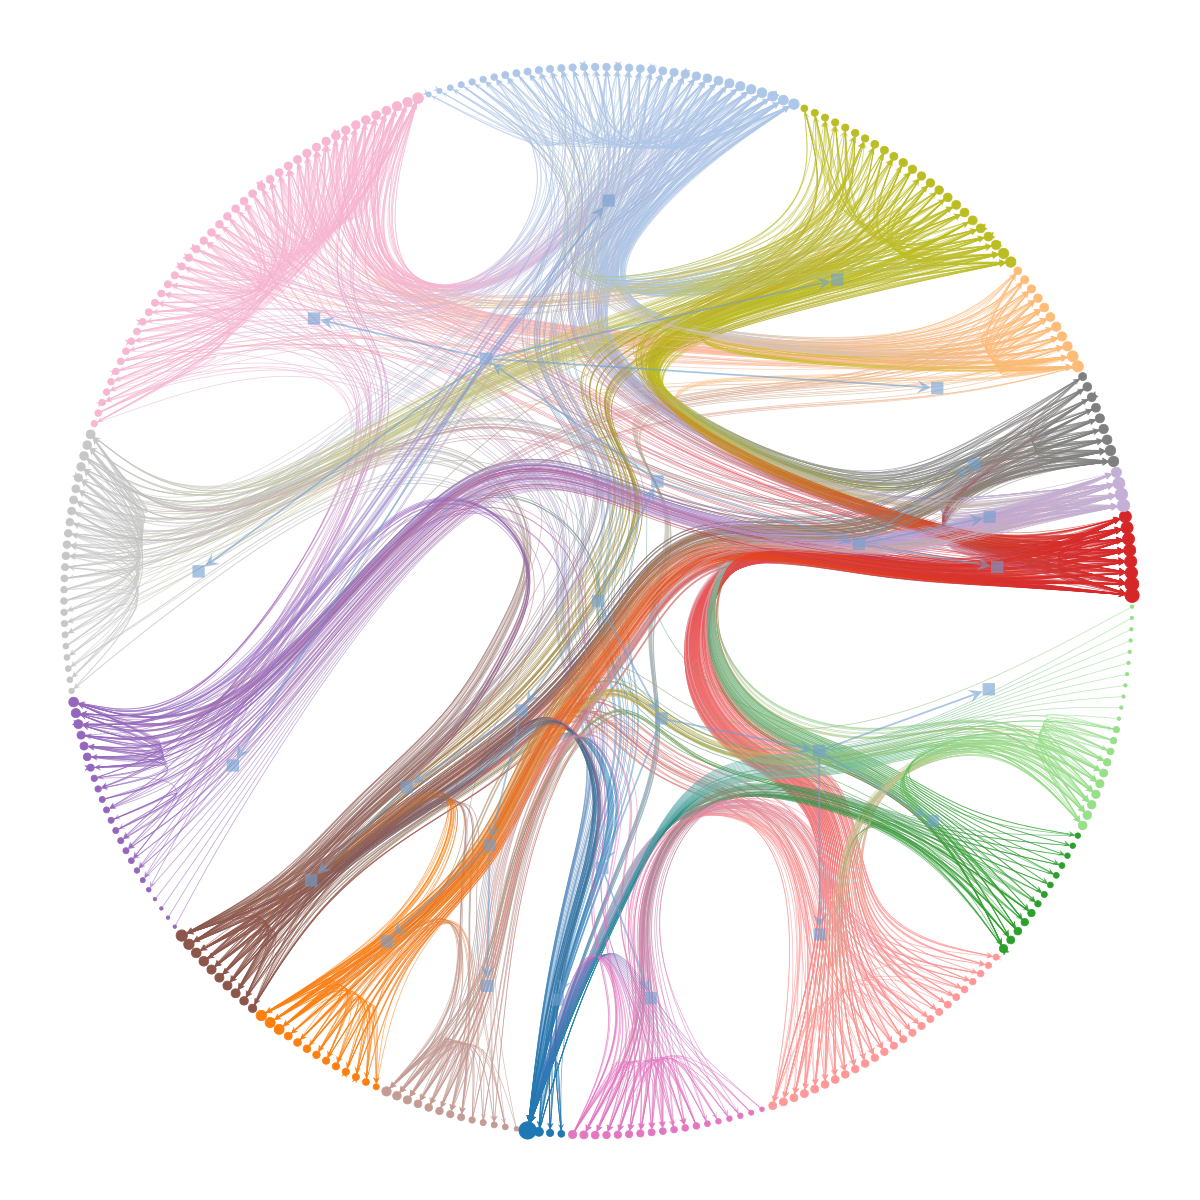

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f832c143530, at 0x7f82e6fd7da0>,
 <GraphView object, directed, with 324 vertices and 323 edges, edges filtered by <EdgePropertyMap object with value type 'bool', for Graph 0x7f82e6fd7800, at 0x7f831eafa3f0>, vertices filtered by <VertexPropertyMap object with value type 'bool', for Graph 0x7f82e6fd7800, at 0x7f82e6fc1880>, at 0x7f82e6fd7800>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f82e6fd7800, at 0x7f82e6fd5550>)

In [7]:
state.draw()

In [8]:
import pandas as pd
import networkx as nx
from pathlib import Path

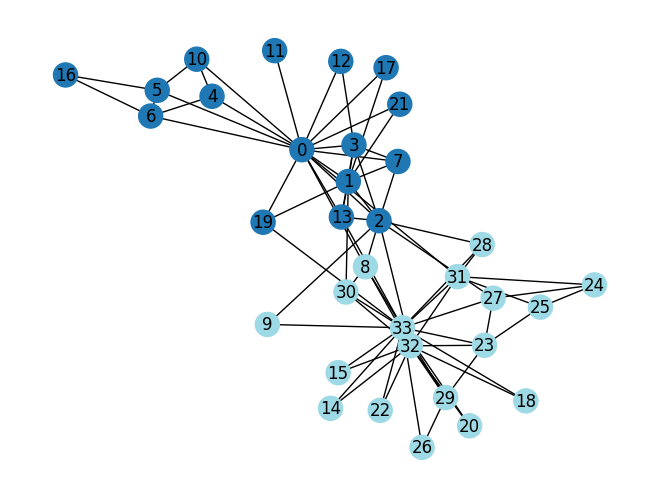

In [9]:
def fit_dcsbm(G, q=None, deg_corr=True):
    import graph_tool.all as gt
    from graph_tool.inference import minimize_blockmodel_dl, BlockState
    # convert networkx -> graph-tool preserving node order
    nodes = list(G.nodes())
    g = gt.Graph(directed=False)
    g.add_vertex(len(nodes))
    idx = {n: i for i, n in enumerate(nodes)}
    for u, v in G.edges():
        g.add_edge(g.vertex(idx[u]), g.vertex(idx[v]))
    # fit model (q fixes number of blocks when provided)
    state_args = dict(deg_corr=deg_corr)
    if q is None:
        state = minimize_blockmodel_dl(g, state=BlockState, state_args=state_args)
    else:
        state = minimize_blockmodel_dl(g, state=BlockState, state_args=state_args, multilevel_mcmc_args=dict(B_min=q, B_max=q))
    labels = list(state.get_blocks())
    # re-label blocks to 0,...,q-1
    unique_labels = sorted(set(labels))
    label_map = {old: new for new, old in enumerate(unique_labels)}
    labels = [label_map[l] for l in labels]
    # map labels back to original networkx node order
    return [labels[idx[n]] for n in nodes]

# Import the Karate Club graph
karate = nx.karate_club_graph()

# Fit a DCSBM to the graph
labels = fit_dcsbm(karate, q=2, deg_corr=True)

pos = nx.spring_layout(karate, seed=43)
nx.draw(karate, pos, node_color=labels, cmap='tab20', with_labels=True)

In [10]:
# Local paths (no URL)
nodes_path = Path("graph_nodes.csv") if Path("graph_nodes.csv").exists() else Path("data/graph_nodes.csv")
edges_path = Path("graph_edges.csv") if Path("graph_edges.csv").exists() else Path("data/graph_edges.csv")

# Read CSVs
nodes = pd.read_csv(nodes_path)
edges = pd.read_csv(edges_path)

# Build undirected graph from edge list (columns: ID1, ID2)
G = nx.from_pandas_edgelist(edges, source="ID1", target="ID2", create_using=nx.Graph())

# Attach node attributes: all columns except 'ID'
attr = nodes.set_index("ID").to_dict("index")
G.add_nodes_from(attr.keys())
nx.set_node_attributes(G, attr)

print(G)

# Print the first 3 nodes with attributes
for i, (node, data) in enumerate(G.nodes(data=True)):
    if i >= 3:
        break
    print(f"Node {node}: {data}")

# Graph with 130 nodes and 806 edges
# Node 0: {'Age': 20, 'Gender': 'female', 'Hobbies': 'hiking,gaming'}
# Node 1: {'Age': 68, 'Gender': 'male', 'Hobbies': 'art,hiking,reading,travel'}
# Node 3: {'Age': 27, 'Gender': 'male', 'Hobbies': 'dancing,hiking'}

Graph with 130 nodes and 806 edges
Node 0: {'Age': 20, 'Gender': 'female', 'Hobbies': 'hiking,gaming'}
Node 1: {'Age': 68, 'Gender': 'male', 'Hobbies': 'art,hiking,reading,travel'}
Node 3: {'Age': 27, 'Gender': 'male', 'Hobbies': 'dancing,hiking'}


In [11]:
num_runs_sbm = 100
sbm_results = []

print(f"Fitting SBM with q=3 for {num_runs_sbm} runs...")
for run in range(num_runs_sbm):
    # Fit standard SBM (deg_corr=False) with 3 blocks
    labels_sbm = fit_dcsbm(G, q=3, deg_corr=False)
    sbm_results.append(labels_sbm)

    if (run + 1) % 20 == 0:
        print(f"  Completed {run + 1}/{num_runs_sbm} runs")

print(f"\nSBM fitting complete!")
print(f"Total runs: {len(sbm_results)}")
print(f"Number of nodes: {len(sbm_results[0])}")
print(f"Number of blocks: {len(set(sbm_results[0]))}")

# Show distribution of block assignments for first run
from collections import Counter
block_counts = Counter(sbm_results[0])
print(f"\nBlock sizes in first run:")
for block_id in sorted(block_counts.keys()):
    print(f"  Block {block_id}: {block_counts[block_id]} nodes")

Fitting SBM with q=3 for 100 runs...
  Completed 20/100 runs
  Completed 40/100 runs
  Completed 60/100 runs
  Completed 80/100 runs
  Completed 100/100 runs

SBM fitting complete!
Total runs: 100
Number of nodes: 130
Number of blocks: 3

Block sizes in first run:
  Block 0: 84 nodes
  Block 1: 24 nodes
  Block 2: 22 nodes


In [13]:
import numpy as np
from collections import Counter

# Check age distribution across communities in 100 SBM runs
runs_with_10percent_diff = 0

# Get node ages from graph attributes
node_list = list(G.nodes())
node_ages = {node: G.nodes[node]['Age'] for node in node_list}

for run_idx, labels in enumerate(sbm_results):
    # Group nodes by their block assignment
    blocks = {}
    for node_idx, block_id in enumerate(labels):
        node = node_list[node_idx]
        if block_id not in blocks:
            blocks[block_id] = []
        blocks[block_id].append(node)

    # Calculate average age for each block
    block_avg_ages = {}
    for block_id, nodes_in_block in blocks.items():
        ages = [node_ages[node] for node in nodes_in_block]
        avg_age = np.mean(ages)
        block_avg_ages[block_id] = avg_age

    # Find min and max average ages
    min_avg_age = min(block_avg_ages.values())
    max_avg_age = max(block_avg_ages.values())

    # Check if min is 10% less than max
    # "10% less" means: min_avg_age < max_avg_age * 0.9
    if min_avg_age < max_avg_age * 0.9:
        runs_with_10percent_diff += 1

print(f"Age Distribution Analysis across 100 SBM runs:")
print(f"=" * 60)
print(f"Runs where lowest avg age < 90% of highest avg age: {runs_with_10percent_diff}/{num_runs_sbm}")
print(f"Percentage: {(runs_with_10percent_diff / num_runs_sbm) * 100:.1f}%")
print(f"\nIs this more than 10 runs? {'Yes' if runs_with_10percent_diff > 10 else 'No'}")

Age Distribution Analysis across 100 SBM runs:
Runs where lowest avg age < 90% of highest avg age: 53/100
Percentage: 53.0%

Is this more than 10 runs? Yes


In [14]:
# Chi-squared test for gender distribution across communities in 100 SBM runs
from scipy.stats import chi2_contingency

significant_runs = 0
alpha = 0.05  # Significance level
p_values = []

# Get node genders from graph attributes
node_genders = {node: G.nodes[node]['Gender'] for node in node_list}

for run_idx, labels in enumerate(sbm_results):
    # Create DataFrame with node, block, and gender
    data_dict = {
        'node': node_list,
        'block': labels,
        'gender': [node_genders[node] for node in node_list]
    }
    df = pd.DataFrame(data_dict)

    # Create contingency table using pandas crosstab
    contingency_table = pd.crosstab(df['block'], df['gender'])

    # Perform chi-squared test for independence
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    p_values.append(p_value)

    # Check if significant at alpha = 0.05
    if p_value < alpha:
        significant_runs += 1

print(f"Chi-Squared Test for Gender Distribution across 100 SBM runs:")
print(f"=" * 60)
print(f"Significance level (alpha): {alpha}")
print(f"Significant runs (p < {alpha}): {significant_runs}/{num_runs_sbm}")
print(f"Percentage: {(significant_runs / num_runs_sbm) * 100:.1f}%")
print(f"\nIs this more than 10 runs? {'Yes' if significant_runs > 10 else 'No'}")
print(f"\nP-value statistics:")
print(f"  Min p-value: {min(p_values):.4f}")
print(f"  Max p-value: {max(p_values):.4f}")
print(f"  Mean p-value: {np.mean(p_values):.4f}")
print(f"  Median p-value: {np.median(p_values):.4f}")

Chi-Squared Test for Gender Distribution across 100 SBM runs:
Significance level (alpha): 0.05
Significant runs (p < 0.05): 1/100
Percentage: 1.0%

Is this more than 10 runs? No

P-value statistics:
  Min p-value: 0.0116
  Max p-value: 0.9922
  Mean p-value: 0.5514
  Median p-value: 0.5339


In [15]:
# Check for male-dominated communities and age correlation in G
runs_with_male_dominated = 0

for run_idx, labels in enumerate(sbm_results):
    # Group nodes by their block assignment
    blocks = {}
    for node_idx, block_id in enumerate(labels):
        node = node_list[node_idx]
        if block_id not in blocks:
            blocks[block_id] = []
        blocks[block_id].append(node)

    # Check each community for >60% male composition
    has_male_dominated_community = False
    for block_id, nodes_in_block in blocks.items():
        genders = [node_genders[node] for node in nodes_in_block]
        male_count = sum(1 for g in genders if g == 'male')
        male_percentage = (male_count / len(genders)) * 100

        if male_percentage > 60:
            has_male_dominated_community = True
            break

    if has_male_dominated_community:
        runs_with_male_dominated += 1

percentage_male_dominated = (runs_with_male_dominated / num_runs_sbm) * 100

print(f"Male-Dominated Community Analysis:")
print(f"=" * 60)
print(f"Runs with at least one community >60% male: {runs_with_male_dominated}/{num_runs_sbm}")
print(f"Percentage: {percentage_male_dominated:.1f}%")
print(f"Is this over 90%? {'Yes' if percentage_male_dominated > 90 else 'No'}")

# Check age correlation among connections in G
print(f"\n{'='*60}")
print(f"Age Correlation Among Connected Nodes:")
print(f"=" * 60)

# Get ages of connected node pairs
age_pairs = []
for u, v in G.edges():
    age_u = G.nodes[u]['Age']
    age_v = G.nodes[v]['Age']
    age_pairs.append((age_u, age_v))

# Calculate correlation coefficient
ages_u = [pair[0] for pair in age_pairs]
ages_v = [pair[1] for pair in age_pairs]
correlation = np.corrcoef(ages_u, ages_v)[0, 1]

print(f"Correlation coefficient between ages of connected nodes: {correlation:.4f}")
print(f"Is correlation > 0.1? {'Yes' if correlation > 0.1 else 'No'}")

if correlation > 0.1:
    print(f"\n✓ The graph shows age homophily (positive age correlation)")
else:
    print(f"\n✗ The graph does not show strong age homophily")

Male-Dominated Community Analysis:
Runs with at least one community >60% male: 27/100
Percentage: 27.0%
Is this over 90%? No

Age Correlation Among Connected Nodes:
Correlation coefficient between ages of connected nodes: 0.1448
Is correlation > 0.1? Yes

✓ The graph shows age homophily (positive age correlation)


In [17]:
# Analyze community sizes, node placement, and edge densities
largest_comm_sizes = []
smallest_comm_sizes = []
max_degree_in_max_avg_degree = 0
within_block_densities = []
between_block_densities = []

# Get degree dictionary and find node with largest degree
degrees = dict(G.degree())
max_degree_node = max(degrees, key=degrees.get)

for run_idx, labels in enumerate(sbm_results):
    # Group nodes by their block assignment
    blocks = {}
    for node_idx, block_id in enumerate(labels):
        node = node_list[node_idx]
        if block_id not in blocks:
            blocks[block_id] = []
        blocks[block_id].append(node)

    # Track community sizes
    comm_sizes = [len(nodes) for nodes in blocks.values()]
    largest_comm_sizes.append(max(comm_sizes))
    smallest_comm_sizes.append(min(comm_sizes))

    # Calculate average degree for each community
    comm_avg_degrees = []
    for block_id, nodes_in_block in blocks.items():
        avg_degree = np.mean([degrees[node] for node in nodes_in_block])
        comm_avg_degrees.append((block_id, avg_degree))

    # Find community with largest average degree
    max_avg_degree_block_id = max(comm_avg_degrees, key=lambda x: x[1])[0]

    # Check if max degree node is in this community
    if max_degree_node in blocks[max_avg_degree_block_id]:
        max_degree_in_max_avg_degree += 1

    # Calculate within-block and between-block edge densities
    within_edges = 0
    within_possible = 0
    between_edges = 0
    between_possible = 0

    # Count edges and possible edges
    for u, v in G.edges():
        label_u = labels[node_list.index(u)]
        label_v = labels[node_list.index(v)]

        if label_u == label_v:
            within_edges += 1
        else:
            between_edges += 1

    # Calculate possible edges for within and between blocks
    for block_id, nodes_in_block in blocks.items():
        n = len(nodes_in_block)
        within_possible += n * (n - 1) // 2  # Combinations within block

    # Total possible edges minus within-block possibilities
    total_nodes = len(node_list)
    total_possible = total_nodes * (total_nodes - 1) // 2
    between_possible = total_possible - within_possible

    # Calculate densities
    within_density = within_edges / within_possible if within_possible > 0 else 0
    between_density = between_edges / between_possible if between_possible > 0 else 0

    within_block_densities.append(within_density)
    between_block_densities.append(between_density)

# Calculate statistics
avg_largest_comm = np.mean(largest_comm_sizes)
avg_smallest_comm = np.mean(smallest_comm_sizes)
percentage_max_in_max = (max_degree_in_max_avg_degree / num_runs_sbm) * 100
avg_within_density = np.mean(within_block_densities)
avg_between_density = np.mean(between_block_densities)

print(f"Community Size and Structure Analysis:")
print(f"=" * 60)
print(f"Average size of largest community: {avg_largest_comm:.2f} nodes")
print(f"Average size of smallest community: {avg_smallest_comm:.2f} nodes")

print(f"\n{'='*60}")
print(f"Max Degree Node Placement:")
print(f"=" * 60)
print(f"Max degree node (Node {max_degree_node}, degree={degrees[max_degree_node]}):")
print(f"Found in community with largest avg degree: {max_degree_in_max_avg_degree}/{num_runs_sbm} times ({percentage_max_in_max:.1f}%)")
print(f"Is this more than 30%? {'Yes' if percentage_max_in_max > 30 else 'No'}")

print(f"\n{'='*60}")
print(f"Edge Density Analysis:")
print(f"=" * 60)
print(f"Average within-block edge density: {avg_within_density:.4f}")
print(f"Average between-block edge density: {avg_between_density:.4f}")
print(f"Within-block density exceeds between-block density? {'Yes' if avg_within_density > avg_between_density else 'No'}")
print(f"Ratio (within/between): {avg_within_density / avg_between_density:.2f}x" if avg_between_density > 0 else "N/A")

Community Size and Structure Analysis:
Average size of largest community: 84.05 nodes
Average size of smallest community: 15.45 nodes

Max Degree Node Placement:
Max degree node (Node 28, degree=22):
Found in community with largest avg degree: 36/100 times (36.0%)
Is this more than 30%? Yes

Edge Density Analysis:
Average within-block edge density: 0.1232
Average between-block edge density: 0.0710
Within-block density exceeds between-block density? Yes
Ratio (within/between): 1.74x


In [18]:
# Fit DCSBM (Degree-Corrected SBM) with q=3 for 100 runs
num_runs_dcsbm = 100
dcsbm_results = []

print(f"Fitting DCSBM (Poisson edge distribution) with q=3 for {num_runs_dcsbm} runs...")
for run in range(num_runs_dcsbm):
    # Fit DCSBM (deg_corr=True) with 3 blocks
    labels_dcsbm = fit_dcsbm(G, q=3, deg_corr=True)
    dcsbm_results.append(labels_dcsbm)

    if (run + 1) % 20 == 0:
        print(f"  Completed {run + 1}/{num_runs_dcsbm} runs")

print(f"\nDCSBM fitting complete!")
print(f"Total runs: {len(dcsbm_results)}")
print(f"Number of nodes: {len(dcsbm_results[0])}")
print(f"Number of blocks: {len(set(dcsbm_results[0]))}")

# Show distribution of block assignments for first run
block_counts_dcsbm = Counter(dcsbm_results[0])
print(f"\nBlock sizes in first run:")
for block_id in sorted(block_counts_dcsbm.keys()):
    print(f"  Block {block_id}: {block_counts_dcsbm[block_id]} nodes")

Fitting DCSBM (Poisson edge distribution) with q=3 for 100 runs...
  Completed 20/100 runs
  Completed 40/100 runs
  Completed 60/100 runs
  Completed 80/100 runs
  Completed 100/100 runs

DCSBM fitting complete!
Total runs: 100
Number of nodes: 130
Number of blocks: 3

Block sizes in first run:
  Block 0: 23 nodes
  Block 1: 80 nodes
  Block 2: 27 nodes


In [20]:
# Analyze DCSBM results: community sizes, node placement, and edge densities
dcsbm_largest_comm_sizes = []
dcsbm_smallest_comm_sizes = []
dcsbm_max_degree_in_max_avg_degree = 0
dcsbm_within_block_densities = []
dcsbm_between_block_densities = []

# Get degree dictionary and find node with largest degree
degrees = dict(G.degree())
max_degree_node = max(degrees, key=degrees.get)
node_list = list(G.nodes())

for run_idx, labels in enumerate(dcsbm_results):
    # Group nodes by their block assignment
    blocks = {}
    for node_idx, block_id in enumerate(labels):
        node = node_list[node_idx]
        if block_id not in blocks:
            blocks[block_id] = []
        blocks[block_id].append(node)

    # Track community sizes
    comm_sizes = [len(nodes) for nodes in blocks.values()]
    dcsbm_largest_comm_sizes.append(max(comm_sizes))
    dcsbm_smallest_comm_sizes.append(min(comm_sizes))

    # Calculate average degree for each community
    comm_avg_degrees = []
    for block_id, nodes_in_block in blocks.items():
        avg_degree = np.mean([degrees[node] for node in nodes_in_block])
        comm_avg_degrees.append((block_id, avg_degree))

    # Find community with largest average degree
    max_avg_degree_block_id = max(comm_avg_degrees, key=lambda x: x[1])[0]

    # Check if max degree node is in this community
    if max_degree_node in blocks[max_avg_degree_block_id]:
        dcsbm_max_degree_in_max_avg_degree += 1

    # Calculate within-block and between-block edge densities
    within_edges = 0
    between_edges = 0

    # Count edges
    for u, v in G.edges():
        label_u = labels[node_list.index(u)]
        label_v = labels[node_list.index(v)]

        if label_u == label_v:
            within_edges += 1
        else:
            between_edges += 1

    # Calculate possible edges for within and between blocks
    within_possible = 0
    for block_id, nodes_in_block in blocks.items():
        n = len(nodes_in_block)
        within_possible += n * (n - 1) // 2  # Combinations within block

    # Total possible edges minus within-block possibilities
    total_nodes = len(node_list)
    total_possible = total_nodes * (total_nodes - 1) // 2
    between_possible = total_possible - within_possible

    # Calculate densities
    within_density = within_edges / within_possible if within_possible > 0 else 0
    between_density = between_edges / between_possible if between_possible > 0 else 0

    dcsbm_within_block_densities.append(within_density)
    dcsbm_between_block_densities.append(between_density)

# Calculate statistics
dcsbm_avg_largest_comm = np.mean(dcsbm_largest_comm_sizes)
dcsbm_avg_smallest_comm = np.mean(dcsbm_smallest_comm_sizes)
dcsbm_percentage_max_in_max = (dcsbm_max_degree_in_max_avg_degree / num_runs_dcsbm) * 100
dcsbm_avg_within_density = np.mean(dcsbm_within_block_densities)
dcsbm_avg_between_density = np.mean(dcsbm_between_block_densities)

print(f"DCSBM Community Size and Structure Analysis:")
print(f"=" * 60)
print(f"Average size of largest community: {dcsbm_avg_largest_comm:.2f} nodes")
print(f"Average size of smallest community: {dcsbm_avg_smallest_comm:.2f} nodes")

print(f"\n{'='*60}")
print(f"Max Degree Node Placement:")
print(f"=" * 60)
print(f"Max degree node (Node {max_degree_node}, degree={degrees[max_degree_node]}):")
print(f"Found in community with largest avg degree: {dcsbm_max_degree_in_max_avg_degree}/{num_runs_dcsbm} times ({dcsbm_percentage_max_in_max:.1f}%)")
print(f"Is this more than 40%? {'Yes' if dcsbm_percentage_max_in_max > 40 else 'No'}")

print(f"\n{'='*60}")
print(f"Edge Density Analysis:")
print(f"=" * 60)
print(f"Average within-block edge density: {dcsbm_avg_within_density:.4f}")
print(f"Average between-block edge density: {dcsbm_avg_between_density:.4f}")
print(f"Within-block density exceeds between-block density? {'Yes' if dcsbm_avg_within_density > dcsbm_avg_between_density else 'No'}")
print(f"Ratio (within/between): {dcsbm_avg_within_density / dcsbm_avg_between_density:.2f}x" if dcsbm_avg_between_density > 0 else "N/A")

DCSBM Community Size and Structure Analysis:
Average size of largest community: 89.83 nodes
Average size of smallest community: 12.48 nodes

Max Degree Node Placement:
Max degree node (Node 28, degree=22):
Found in community with largest avg degree: 23/100 times (23.0%)
Is this more than 40%? No

Edge Density Analysis:
Average within-block edge density: 0.1200
Average between-block edge density: 0.0718
Within-block density exceeds between-block density? Yes
Ratio (within/between): 1.67x
